In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

- Collect average transaction size for a credit card
- Average longitude and latitude of transactions
- Average time of transaction
- 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
folder_location = '/content/gdrive/MyDrive/Colab Notebooks/DS4400: ML Project/' 
training = pd.read_csv(folder_location + 'fraudTrain.csv')  
testing = pd.read_csv(folder_location + 'fraudTest.csv')

FileNotFoundError: ignored

In [ ]:
testing.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


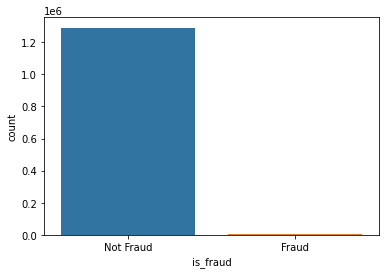

In [ ]:
# visualize the target variable - clearly our data is highly imbalanced and something must be done to fix this issue
g = sns.countplot(training['is_fraud'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

In [ ]:
from time import mktime
from sklearn.preprocessing import MinMaxScaler

def normalize_features(X_train, X_test):
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  return X_train_scaled, X_test_scaled

def engineer_datetime(df):
  df["datetime"] = df["trans_date_trans_time"].apply(pd.to_datetime)
  df["hour"] = df["datetime"].dt.hour
  df["day"] = df["datetime"].dt.day
  df["month"] = df["datetime"].dt.month
  df["unix_purchase_time"] = df["datetime"].apply(lambda dt: mktime(dt.timetuple()))
  dob_dt = df["dob"].apply(pd.to_datetime)
  dob_year = dob_dt.dt.year 
  df["dob_year"] = dob_year
  df["unix_dob"] = dob_dt.apply(lambda dt: mktime(dt.timetuple()))
  df = df.drop(["trans_date_trans_time", "dob"], axis=1)
  return df

def engineer_features(df):
  df = engineer_datetime(df)
  df = df.drop(["state", "city", "Unnamed: 0", "merchant", "first", "last", "street", "zip", "job", "unix_time"], axis=1)
  df["is_man"] = df["gender"].apply(lambda x: 0 if x == "F" else 1)
  df = df.drop("gender", axis=1)
  df.reset_index(inplace=True)
  #df = pd.DataFrame(df, dtype={'amt': float, 'lat': float, 'long': float, 'city_pop': float, 'merch_lat': float, 'merch_long': float})
  df = df.astype({'amt': float, 'lat': float, 'long': float, 'city_pop': float, 'merch_lat': float, 'merch_long': float})
  obj_df = df.select_dtypes(include=['object']).copy()
  obj_df_encoded = pd.get_dummies(obj_df, columns=["category"], prefix=["category"])
  df = df.drop(["category"], axis=1)
  obj_df_encoded.reset_index(inplace=True)
  df = pd.concat([df,obj_df_encoded],axis=1).drop("index", axis=1)
  df = df.loc[:,~df.columns.duplicated()]
  means = df.apply(concat_averages, frame=df, axis=1)
  df = df.merge(means, left_on='trans_num', right_on='trans_num')
  df.drop(['datetime', 'cc_num', 'trans_num'], axis=1, inplace=True)
  return df


def f(x):
    d = {}
    d['amt_mean'] = x['amt'].mean()
    d['amt_std'] = x['amt'].std()
    d['amt_count'] = x['amt'].count()
    d['merch_lat_mean'] = x['merch_lat'].mean()
    d['merch_lat_std'] = x['merch_lat'].std()
    d['merch_long_mean'] = x['merch_long'].mean()
    d['merch_long_std'] = x['merch_long'].std()
    d['is_fraud_mean'] = x['is_fraud'].mean()
    d['is_fraud_std'] = x['is_fraud'].std()
    d['previous_frauds_for_cc_num'] = d['amt_count'] * d['is_fraud_mean']
    return pd.Series(d, index=['amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num'])

def concat_averages(row, frame):
  date = row['datetime']
  cc_num = row['cc_num']
  frame_before_date = frame.loc[ (frame["cc_num"] == cc_num) & (frame['datetime'] < date)].copy()
  frame_before_date.drop(columns=['city_pop', 'lat', 'long'], inplace=True)
  cc_averages = frame_before_date.groupby("cc_num").apply(f)
  cc_averages = cc_averages.fillna(0)
  indices = ['amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num']
  if len(cc_averages.values) == 0:
    zeros = np.zeros(len(indices))
    series = pd.Series(zeros, index=indices)
  else:
    series = pd.Series(cc_averages.values[0], index=indices)
  series['trans_num'] = row['trans_num']
  return series


In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

y_train = training["is_fraud"]
X_train = training.drop(["is_fraud"], axis = 1)

# summarize class distribution
print("Before undersampling: ", Counter(y_train))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy=.1)

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print("After undersampling: ", Counter(y_train_under))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Before undersampling:  Counter({0: 1289169, 1: 7506})
After undersampling:  Counter({0: 75060, 1: 7506})


In [ ]:
#PART 2
# import SVM libraries 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split


x_train_unused, X_test, y_train, y_test = train_test_split(testing.drop(["is_fraud"], axis=1), testing["is_fraud"], test_size = 0.1)

X_train_under_df = pd.DataFrame(X_train_under, columns=training.drop(["is_fraud"], axis=1).columns)
X_test_df = pd.DataFrame(X_test, columns=training.drop(["is_fraud"], axis=1).columns)
X_train_under_df['is_fraud'] = y_train_under
print(X_train_under_df.shape, X_test_df.shape)
X_train_under_df = engineer_features(X_train_under_df)
X_test_df['is_fraud'] = y_test
X_test_df = engineer_features(X_test_df)

X_train_under_df.drop('is_fraud', axis=1, inplace=True)
X_test_df.drop('is_fraud', axis=1, inplace=True)

X_train_under_df.head()

(82566, 23) (55572, 22)


,amt,lat,long,city_pop,merch_lat,merch_long,hour,day,month,unix_purchase_time,dob_year,unix_dob,is_man,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,amt_mean,amt_std,amt_count,merch_lat_mean,merch_lat_std,merch_long_mean,merch_long_std,is_fraud_mean,is_fraud_std,previous_frauds_for_cc_num
0,58.56,35.8596,-86.4210,158701.0,36.793706,-87.133724,3,29,10,1.572322e+09,1978,257990400.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,95.858947,196.214768,76.0,35.955165,0.548922,-86.267949,0.578868,0.092105,0.291096,7.0
1,2.71,29.7972,-95.3288,2906700.0,29.568016,-95.690836,12,2,6,1.591101e+09,1983,430531200.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,169.074082,276.313856,98.0,29.835810,0.532738,-95.231356,0.562336,0.142857,0.351726,14.0
2,82.47,39.3900,-88.9597,1532.0,38.714378,-89.664117,19,24,2,1.582571e+09,1980,316224000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,91.177059,78.309482,68.0,39.409659,0.604306,-89.016981,0.586922,0.000000,0.000000,0.0
3,66.16,41.4972,-98.7858,509.0,41.235883,-99.250083,22,6,2,1.581026e+09,1980,337824000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,78.031087,257.800944,92.0,41.630772,0.531682,-98.685780,0.561790,0.000000,0.000000,0.0
4,63.54,44.5232,-86.2061,680.0,44.904476,-85.388611,0,25,5,1.590366e+09,1966,-95644800.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,121.207527,234.932531,93.0,44.488731,0.555748,-86.154317,0.581499,0.075269,0.265255,7.0


In [ ]:
def create_aggregated_df_to_apply_to_test(train_df):
  lat_long_df = train_df[['lat', 'long', 'amt_count']]
  lat_long_df_agg = lat_long_df.groupby(['lat', 'long']).agg('max')
  lat_long_df_agg.set_index(['amt_count'], append=True, inplace=True)
  lat_long_df_agg.head()
  indices = ['lat', 'long', 'amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num']
  cc_averages_by_lat = train_df[indices]
  cc_averages_by_lat.set_index(['lat', 'long', 'amt_count'], inplace=True)
  df_with_maxes = pd.merge(lat_long_df_agg, cc_averages_by_lat, left_index=True, right_index=True, how="inner")
  df_with_maxes.reset_index(level='amt_count', inplace=True)
  return df_with_maxes

agg_df_to_apply_to_test = create_aggregated_df_to_apply_to_test(X_train_under_df)


In [ ]:
def map_aggregations(row, frame):
  lat = row['lat']
  long = row['long']
  if (lat, long) not in frame.index:
    return row
  else:
    frame_row = frame.loc[(lat, long)]
    if row['amt_count'] == 0:
      row['amt_mean'] = frame_row['amt_mean']
      row['amt_std'] = frame_row['amt_std']
      row['amt_count'] = frame_row['amt_count']
      row['merch_lat_mean'] = frame_row['merch_lat_mean']
      row['merch_lat_std'] = frame_row['merch_lat_std']
      row['merch_long_mean'] = frame_row['merch_long_mean']
      row['merch_long_std'] = frame_row['merch_long_std']
      row['is_fraud_mean'] = frame_row['is_fraud_mean']
      row['is_fraud_std'] = frame_row['is_fraud_std']
      row['previous_frauds_for_cc_num'] = frame_row['previous_frauds_for_cc_num']
      return row
    else:
      test_count = row['amt_count']
      frame_row_count = frame_row['amt_count']

      row['amt_mean'] = combine_means(row['amt_mean'], frame_row['amt_mean'], test_count, frame_row_count)
      row['amt_std'] = combine_std(row['amt_std'], frame_row['amt_std'], test_count, frame_row_count)
      row['amt_count'] = test_count + frame_row_count
      row['merch_lat_mean'] = combine_means(row['merch_lat_mean'], frame_row['merch_lat_mean'], test_count, frame_row_count)
      row['merch_lat_std'] = combine_std(row['merch_lat_std'], frame_row['merch_lat_std'], test_count, frame_row_count)
      row['merch_long_mean'] = combine_means(row['merch_long_mean'], frame_row['merch_long_mean'], test_count, frame_row_count)
      row['merch_long_std'] = combine_std(row['merch_long_std'], frame_row['merch_long_std'], test_count, frame_row_count)
      row['is_fraud_mean'] = combine_means(row['is_fraud_mean'], frame_row['is_fraud_mean'], test_count, frame_row_count)
      row['is_fraud_std'] = combine_std(row['is_fraud_std'], frame_row['is_fraud_std'], test_count, frame_row_count)
      row['previous_frauds_for_cc_num'] = frame_row['previous_frauds_for_cc_num'] + row['previous_frauds_for_cc_num']
      return row

def combine_means(mean1, mean2, n1, n2):
  return (mean1 * n1 + mean2 * n2) / (n1 + n2)

def combine_std(std1, std2, n1, n2):
  var1 = (std1 ** 2) / n1
  var2 = (std2 ** 2) / n2
  return np.sqrt((var1 + var2) / 2)   


In [ ]:
def apply_aggregation_df_to_test(test_df, agg_df):
  return test_df.apply(map_aggregations, frame=agg_df, axis=1)

X_test_df_agg = apply_aggregation_df_to_test(X_test_df, agg_df_to_apply_to_test)

In [ ]:
def add_blank_columns(df_train, df_test):
  for column in df_train.columns:
    if column not in df_test.columns:
      df_test[column] = 0
  for column2 in df_test.columns:
    if column2 not in df_train.columns:
      df_train[column2] = 0
  return df_train, df_test
##X_train_under_df, X_test_df = add_blank_columns(X_train_under_df, X_test_df)

In [ ]:
X_train_scaled_df, X_test_scaled_df = normalize_features(X_train_under_df, X_test_df_agg)

In [ ]:
print(np.isnan(X_train_scaled_df.any())) #and gets False
print(np.isfinite(X_train_scaled_df.all()))
print(np.isnan(np.min(X_train_scaled_df)))

False
True
False


In [ ]:
model=SVC()
clf_under = model.fit(X_train_scaled_df, y_train_under)
pred_under = clf_under.predict(X_test_scaled_df)
pred_train = clf_under.predict(X_train_scaled_df)

print("ROC AUC score for undersampled data: ", roc_auc_score(y_test, pred_under))

ROC AUC score for undersampled data:  0.6985104895918053


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, pred_under))
print(classification_report(y_test, pred_under))
print("--------------------------------------------------------")
print(confusion_matrix(y_train_under, pred_train))
print(classification_report(y_train_under, pred_train))

[[55332    49]
 [  115    76]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55381
           1       0.61      0.40      0.48       191

    accuracy                           1.00     55572
   macro avg       0.80      0.70      0.74     55572
weighted avg       1.00      1.00      1.00     55572

--------------------------------------------------------
[[74860   200]
 [ 2524  4982]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     75060
           1       0.96      0.66      0.79      7506

    accuracy                           0.97     82566
   macro avg       0.96      0.83      0.88     82566
weighted avg       0.97      0.97      0.96     82566



In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators = 100, random_state=0)
ada.fit(X_train_scaled_df, y_train_under)
pred_test = ada.predict(X_test_scaled_df)
pred_train = ada.predict(X_train_scaled_df)
print(classification_report(y_test, pred_test))
print(classification_report(y_train_under, pred_train))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     55381
           1       0.07      0.78      0.13       191

    accuracy                           0.97     55572
   macro avg       0.54      0.87      0.56     55572
weighted avg       1.00      0.97      0.98     55572

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     75060
           1       0.93      0.88      0.91      7506

    accuracy                           0.98     82566
   macro avg       0.96      0.94      0.95     82566
weighted avg       0.98      0.98      0.98     82566



In [ ]:
print(confusion_matrix(y_test, pred_test))

[[53490  1891]
 [   42   149]]
